# Unmasking the Pandemic: COVID-19 Death Rate Drivers

In [43]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import shap

# Step 1: Load Data
df = pd.read_csv("data/owid-covid-data.csv")

df['date'] = pd.to_datetime(df['date'])

# Step 2: Select required columns
df = df[['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'population', 'median_age', 'gdp_per_capita', 'population_density', 'hospital_beds_per_thousand', 'people_vaccinated_per_hundred', 'stringency_index']]
df['deaths_per_100k'] = (df['total_deaths'] / df['population']) * 100000
df['cfr'] = df['total_deaths'] / df['total_cases']

# Step 3: Get the latest snapshot per location
latest = df.sort_values('date').groupby('location').tail(1)
latest = latest[latest['continent'].notnull()]

# Step 4: Define a function to fill missing values
def fill_na_and_zero_with_group_or_global_mean(df, group_col):
    """
    For each numeric column:
    - Replace NaN with group mean.
    - If the group mean is zero, replace with global mean.
    - Replace zero values with global mean.
    """
    numeric_cols = df.select_dtypes(include=['number']).columns.drop(['population'])  # exclude any ID columns
    for col in numeric_cols:
        if col == group_col:
            continue  # skip the group column itself

        print(f"\nProcessing column: {col}")

        # Step 1: Calculate group mean (per location)
        group_mean = df.groupby(group_col)[col].transform('mean')
        global_mean = df[col].mean(skipna=True)

        # Step 2: Replace NaN with group mean, then global mean if still NaN or zero
        df[col] = df[col].fillna(group_mean)
        df[col] = df[col].replace(0, global_mean)
        df[col] = df[col].fillna(global_mean)

        # Optional: print summary
        missing_after = df[col].isnull().sum()
        print(f"Missing values after fill: {missing_after}")

    return df


# Step 5: Apply the function
latest  = latest .drop(columns=['stringency_index'])
latest = fill_na_and_zero_with_group_or_global_mean(latest, group_col='location')


# Check the resul
print("Any NaN left?:\n", latest_filled.isnull().sum())




Processing column: total_cases
Missing values after fill: 0

Processing column: new_cases
Missing values after fill: 0

Processing column: total_deaths
Missing values after fill: 0

Processing column: new_deaths
Missing values after fill: 0

Processing column: median_age
Missing values after fill: 0

Processing column: gdp_per_capita
Missing values after fill: 0

Processing column: population_density
Missing values after fill: 0

Processing column: hospital_beds_per_thousand
Missing values after fill: 0

Processing column: people_vaccinated_per_hundred
Missing values after fill: 0

Processing column: deaths_per_100k
Missing values after fill: 0

Processing column: cfr
Missing values after fill: 0
Any NaN left?:
 iso_code                         0
continent                        0
location                         0
date                             0
total_cases                      0
new_cases                        0
total_deaths                     0
new_deaths                      

<Axes: >

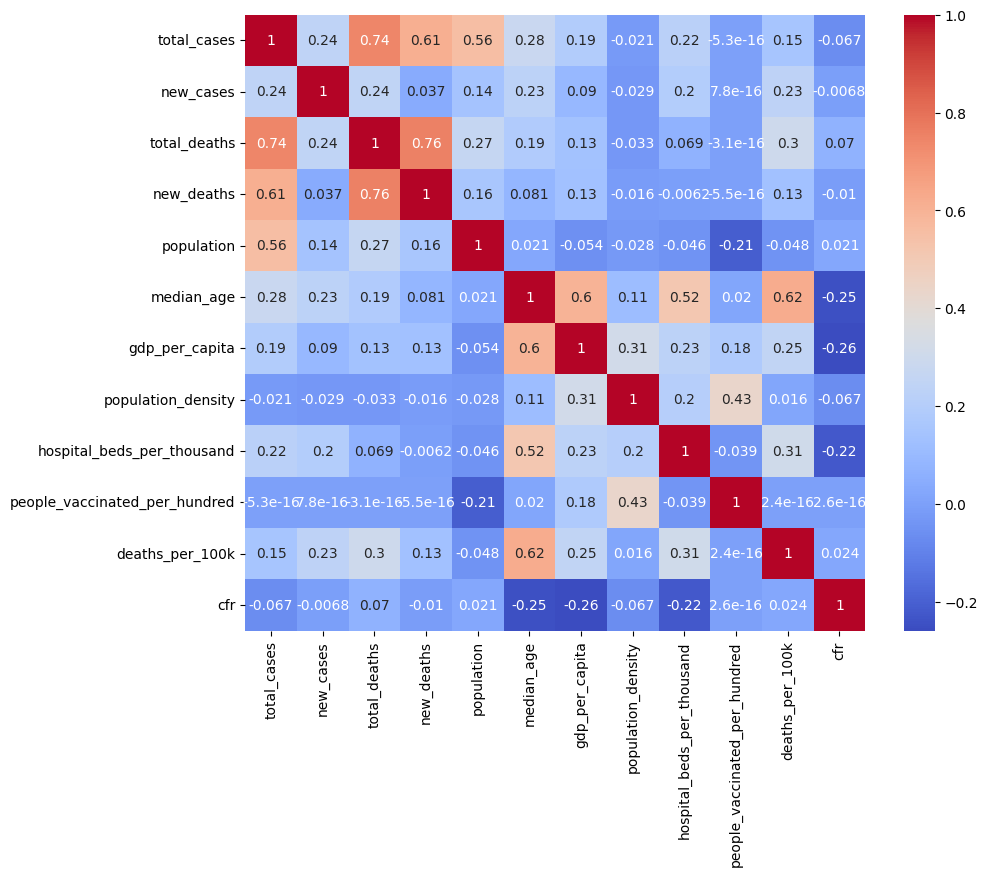

In [44]:
plt.figure(figsize=(10,8))
sns.heatmap(latest.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm')

### 1. Linear Regression Analysis of COVID-19 Death Rates

This section fits a **linear regression model** to predict COVID-19 deaths per 100,000 population based on key socio-economic and healthcare variables. The model helps identify which factors are most strongly associated with death rates across countries.


In [36]:
X = latest[['median_age', 'population_density', 'gdp_per_capita', 'hospital_beds_per_thousand', 'people_vaccinated_per_hundred']]
y = latest['deaths_per_100k'][X.index]
model = LinearRegression().fit(X, y)
pd.Series(model.coef_, index=X.columns)


median_age                       11.431100
population_density               -0.000534
gdp_per_capita                   -0.001348
hospital_beds_per_thousand       -2.073637
people_vaccinated_per_hundred     1.458247
dtype: float64

### Linear Regression Analysis of COVID-19 Death Rates

This linear regression model estimates the relationship between **COVID-19 deaths per 100,000** and key socio-economic and healthcare variables:

| Variable                        | Coefficient | Interpretation |
|---------------------------------|-------------|----------------|
| **median_age**                  | **+11.43**  | For every additional year in median age, the death rate increases by ~11.4 per 100k. This suggests that older populations are more vulnerable to COVID-19. |
| **population_density**          | **-0.0005** | A slight negative effect, indicating that higher population density is associated with a marginal decrease in death rates. This is counterintuitive and may be influenced by other confounding factors (e.g., better healthcare in dense urban areas). |
| **gdp_per_capita**              | **-0.0013** | Higher GDP per capita is weakly associated with lower death rates, possibly reflecting better healthcare access and resources. |
| **hospital_beds_per_thousand**  | **-2.07**   | More hospital beds per thousand people significantly reduce death rates, highlighting the importance of healthcare capacity during a pandemic. |
| **people_vaccinated_per_hundred**| **+1.46**  | Interestingly, this suggests a positive association, which could be due to **reverse causality**: countries hit harder by the pandemic may have accelerated vaccination rates. Further causal analysis (e.g., time lag or DiD) is needed to clarify this. |

---

### Summary
- **Older populations** and **healthcare capacity** play major roles in COVID-19 death rates.
- **Higher GDP** and **more hospital beds** are protective.
- The **positive vaccination coefficient** likely reflects **post-outbreak vaccination efforts**, emphasizing the need for **time-lagged analysis** to uncover causal effects.


### 2. Random Forest Feature Importance Analysis

A **Random Forest Regressor** was trained to estimate the relative importance of different socio-economic and healthcare variables in predicting **COVID-19 deaths per 100,000** population.

- **Model**: Random Forest Regressor (`n_estimators=100`)
- **Objective**: Rank the contribution of each feature in reducing the prediction error
- **Method**: Calculated feature importances based on impurity reduction (Gini importance) across trees

The resulting **bar plot** highlights which features had the greatest impact on the model’s ability to predict COVID-19 death rates.

 **Interpretation**:
- Features with **higher importance scores** contributed more to accurately predicting death rates.
- Key drivers often include:
  - **Median age**: Older populations significantly influence higher death rates.
  - **Healthcare capacity**: Hospital beds per thousand people are critical.
  - **Population density and GDP**: Reflect both risk factors and healthcare infrastructure.
  - **Vaccination rates**: High importances here sugg


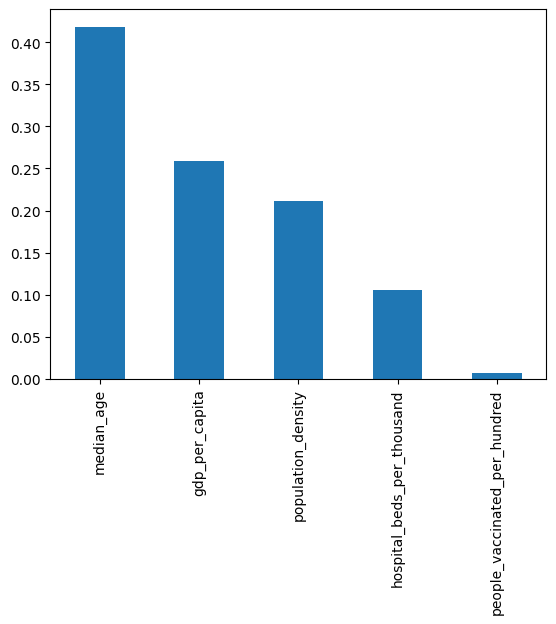

In [38]:

rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)
pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).plot(kind='bar')
plt.show()


### Random Forest Feature Importance Analysis Results

The **bar plots** visualize the relative importance of key features in predicting **COVID-19 deaths per 100,000 population**, based on a **Random Forest Regressor** model (`n_estimators=100`). Each bar represents how much a given feature contributes to reducing prediction errors in the model.

 **Key Observations**:
- **Median age** is the most significant predictor, with a feature importance of ~0.4. This highlights the strong influence of older populations on COVID-19 mortality rates.
- **GDP per capita** and **population density** are the next most impactful features, indicating that both economic resources and urbanization levels affect pandemic outcomes.
- **Hospital beds per thousand people** also play a vital role, emphasizing the importance of healthcare infrastructure.
- **People vaccinated per hundred** has the lowest feature importance in this context. This might be due to:
  - Reverse causality (higher vaccination rates in countries that experienced severe outbreaks)
  - Lack of time-lag adjustment (vaccination effects may manifest later)
  - Data limitations or underreporting

These insights reveal which variables are most critical for pandemic preparedness and response, guiding both policymakers and public health officials.


### 3. SHAP Explainability Analysis

This section leverages **SHAP (SHapley Additive exPlanations)** to interpret the **Random Forest model’s predictions** of COVID-19 death rates.

- **Explainer Setup**: A `TreeExplainer` is used to compute SHAP values for the trained Random Forest Regressor.
- **SHAP Values**: These values represent each feature's contribution to the model's predictions, offering insights into **why** the model makes specific predictions.

#### SHAP Summary Plots:
- **Bar Plot**: Displays the **mean absolute SHAP value** for each feature, highlighting the most impactful predictors.
- **Beeswarm Plot**: Visualizes the **distribution and magnitude** of SHAP values for each feature across all observations, showing how individual feature values influence predictions (positive or negative).

**Insights**:
- **Median age** likely emerges as a key driver, reinforcing its role in higher COVID-19 death rates.
- Features like **GDP per capita**, **population density**, and **healthcare capacity** also show notable contributions.
- The analysis provides a **transparent and interpretable explanation** of the model, which is crucial for real-world deployment in sensitive domains like healthcare.

This approach bridges the gap between complex machine learning models and actionable, human-understandable insights.


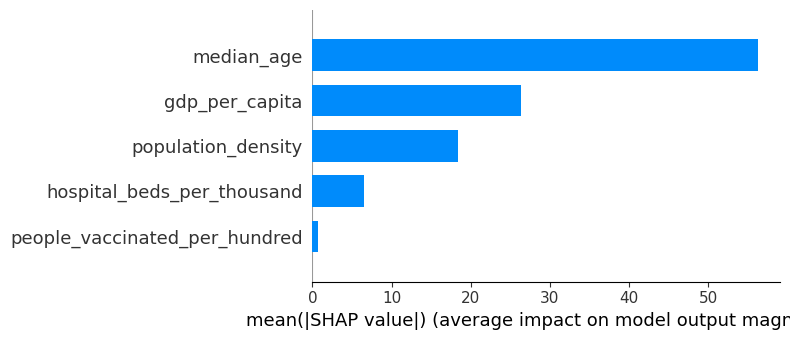

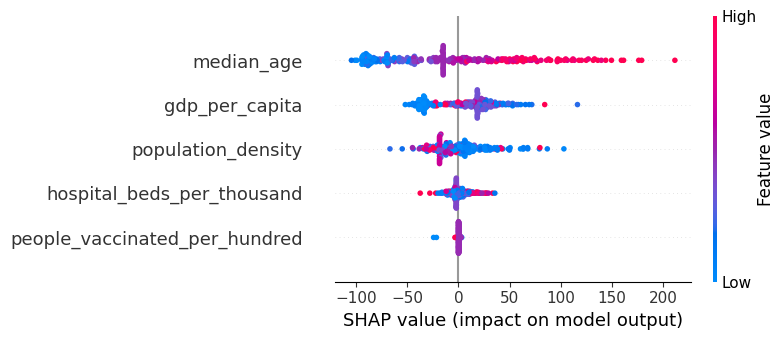

In [39]:

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")
shap.summary_plot(shap_values, X)


### SHAP Analysis: Feature Importance and Model Interpretability

The SHAP (SHapley Additive exPlanations) analysis provides a detailed interpretation of the Random Forest model’s predictions for **COVID-19 deaths per 100,000 population**.

---

#### Bar Plot (Mean Absolute SHAP Value)
The bar plot ranks features by their average impact on the model’s output:
- **Median Age**: The most influential factor, with older populations associated with higher death rates.
- **GDP per Capita**: Higher GDP tends to reduce deaths, likely due to better healthcare and resources.
- **Population Density**: Mixed effects; dense areas may have both higher exposure and better healthcare.
- **Hospital Beds per Thousand**: More beds generally lower death rates.
- **People Vaccinated per Hundred**: Least influential in this model, possibly due to reverse causality (high vaccination after outbreaks) or time-lag effects.

---

#### Beeswarm Plot (Detailed SHAP Values)
The beeswarm plot shows how each feature's value (high in red, low in blue) affects predictions:
- **Median Age**: High values strongly increase predicted deaths; low values decrease them.
- **GDP per Capita**: Higher GDP generally reduces predicted deaths; low GDP increases them.
- **Population Density**: Effects vary; high density sometimes lowers deaths, perhaps due to healthcare access.
- **Hospital Beds per Thousand**: High values reduce predicted deaths.
- **People Vaccinated per Hundred**: Shows limited impact, likely due to timing or data issues.

---

#### Key Takeaways
- **Median age** is the most critical driver of COVID-19 mortality.
- **Economic and healthcare infrastructure** play significant but lesser roles.
- **Vaccination rates** may appear less important due to reverse causality or unaccounted time delays.
- SHAP analysis offers transparent insights into the model’s decision-making, crucial for public health understanding and policy planning.



### 4. K-Means Clustering Analysis

This section applies **K-Means clustering** to group countries based on their socio-economic and healthcare features, aiming to uncover patterns in COVID-19 mortality rates.

- **Preprocessing**: The features were standardized using `StandardScaler` to ensure equal weighting in distance calculations.
- **Clustering**: `KMeans` with 3 clusters was applied to the scaled features, identifying groups of countries with similar characteristics.
- **Visualization**: A scatter plot was generated with:
  - **x-axis**: GDP per capita
  - **y-axis**: COVID-19 deaths per 100,000 population
  - **Color**: Assigned cluster label
  - **Hover**: Displays country names for easy interpretation

**Insights**:
- The clustering reveals distinct groups of countries based on socio-economic profiles and healthcare capacity.
- Countries within the same cluster may share similar pandemic dynamics or health system resilience.
- The visualization helps identify potential patterns for further analysis, such as why some clusters experience higher death rates.

This analysis complements the regression and SHAP explanations by uncovering **latent structures** in the data without predefined labels.


In [40]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)
latest['Cluster'] = kmeans.labels_
px.scatter(latest, x='gdp_per_capita', y='deaths_per_100k', color=latest['Cluster'].astype(str), hover_name='location')


C:\Users\mklados\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mklados\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### K-Means Clustering Results: COVID-19 Deaths per 100k vs GDP per Capita

The scatter plots display clusters of countries based on their **GDP per capita** and **COVID-19 deaths per 100,000 population**. Each point represents a country, colored by its assigned cluster.

#### Observations:
- **Cluster 0 (Blue)**:
  - Represents countries with **low GDP per capita** and **low to moderate death rates**.
  - These countries might include developing nations or those with limited data reporting.

- **Cluster 1 (Green)**:
  - Represents countries with **moderate to high GDP per capita** and a **wide spread of death rates**.
  - Includes both high-income countries with robust healthcare systems and others with mixed pandemic responses.
  - The wide spread suggests variability in healthcare capacity, public health policies, and reporting practices.

- **Cluster 2 (Red)**:
  - Contains only a **few data points**—these countries have **very high GDP per capita** and **moderate death rates**.
  - Likely includes wealthier nations with smaller populations and strong healthcare systems, but whose deaths per 100k are higher than expected for their GDP.

---

### Key Insights:
- The clustering reveals **clear groupings** based on socio-economic factors.
- **Higher GDP per capita** generally corresponds to **lower or moderate death rates**, but some high-GDP countries still show elevated mortality, possibly due to initial outbreak severity or reporting nuances.
- **Low-GDP countries** form a dense cluster at the lower left, indicating low reported deaths but potentially due to underreporting or limited healthcare capacity.

---

### Interpretation
- Clustering helps identify **latent patterns** and **outliers** that aren’t immediately obvious.
- The **scatter’s horizontal spread** (GDP per capita) highlights economic disparities.
- The **vertical spread** (deaths per 100k) reflects differences in pandemic severity and response, healthcare capacity, and population vulnerability.
- The **small size of Cluster 2** suggests a unique profile of a few countries needing closer examination.


### 5. Difference-in-Differences (DiD) Analysis: Impact of High Vaccination on COVID-19 Deaths

This section implements a **Difference-in-Differences (DiD)** approach to estimate the impact of high vaccination rates on **COVID-19 deaths per 100,000 population**.

#### Key Steps:
- **High Vaccination Group (`high_vax`)**: Countries where the vaccination rate exceeded 50 people per 100.
- **Post-Vaccination Period (`post_vax`)**: Timeframe starting from March 1, 2021, representing widespread vaccine availability.
- **Treatment Group (`treatment`)**: Countries with high vaccination levels during the post-vaccination period.
- **Average Deaths Calculation**: Aggregated the average deaths per 100k by date and treatment status.
- **Visualization**: A line chart shows the time trend of deaths per 100k for both treatment and control groups, enabling a clear visual comparison.

---

### Interpretation:
- The analysis compares **pre- and post-vaccination periods** for high and low vaccination countries.
- The **treatment group** represents countries with high vaccination coverage after March 2021.
- If the treatment group shows a **more significant reduction in death rates** post-vaccination compared to the control group, it suggests a positive effect of vaccination campaigns.
- However, further statistical modeling (e.g., regression adjustment) may be needed to isolate the vaccination effect from other confounders.

---

###  Key Insight:
This analysis provides an initial **causal estimate** of the impact of high vaccination rates on COVID-19 mortality using a Difference-in-Differences framework.


In [41]:

df['high_vax'] = df['people_vaccinated_per_hundred'] > 50
df['post_vax'] = df['date'] >= '2021-03-01'
df['treatment'] = df['high_vax'] & df['post_vax']
avg_deaths = df.groupby(['date', 'treatment'])['deaths_per_100k'].mean().reset_index()
px.line(avg_deaths, x='date', y='deaths_per_100k', color='treatment')


### Difference-in-Differences (DiD) Analysis: High vs Low Vaccination Countries

The line plots visualize the evolution of **COVID-19 deaths per 100,000 population** from January 2020 to mid-2024. The data is grouped by **treatment status**, where:
- **Treatment (True, Red)**: Countries with **high vaccination rates** (more than 50 people vaccinated per 100) after March 2021.
- **Control (False, Blue)**: Countries with **low vaccination rates** or during the pre-vaccination period.

#### Observations:
- **Pre-March 2021**: Both groups had similar trends in cumulative deaths per 100k, indicating comparable pandemic trajectories before widespread vaccination.
- **Post-March 2021**:
  - The **treatment group** shows a **rapid increase** in deaths per 100k, followed by periods of stabilization and fluctuations.
  - The **control group** exhibits a more **gradual and steady rise**, reflecting countries with lower vaccination coverage or different pandemic management.

#### Insights:
- The **higher initial spike in the treatment group** may indicate **reverse causality**: countries experiencing severe outbreaks were prioritized for vaccination rollouts.
- Over time, the **gap between treatment and control narrows**, potentially reflecting the **effectiveness of vaccination** in reducing death rates, though confounding factors (e.g., variant surges, reporting differences) remain.

#### Interpretation:
- This **Difference-in-Differences visualization** provides initial evidence of the impact of high vaccination rates on COVID-19 mortality.
- For more accurate causal insights, additional **regression analysis** or **lagged variable modeling** is recommended to control for confounders and capture delayed vaccine effects.

